# Instalando bibliotecas necessárias e configurando o diretório base 

In [11]:
!pip install netCDF4

Import Rocketpy and other libs

In [12]:
from rocketpy import Environment, Rocket, SolidMotor, Flight, Function

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment Conditions

In [13]:
#help(Environment)

Launch Site Details

Launch Rail Length:  50  m
Launch Date:  2020-11-29 12:00:00  UTC
Launch Site Latitude: -23.36361°
Launch Site Longitude: -48.01139°
Launch Site Surface Elevation: 668.0 m


Atmospheric Model Details

Atmospheric Model Type:  CostumAtmosphere
CostumAtmosphere Maximum Height: 6.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 4.27 m/s
Surface Wind Direction: 290.91°
Surface Wind Heading: 110.91°
Surface Pressure: 941.41 hPa
Surface Temperature: 299.16 K
Surface Air Density: 1.096 kg/m³
Surface Speed of Sound: 346.73 m/s


Atmospheric Model Plots


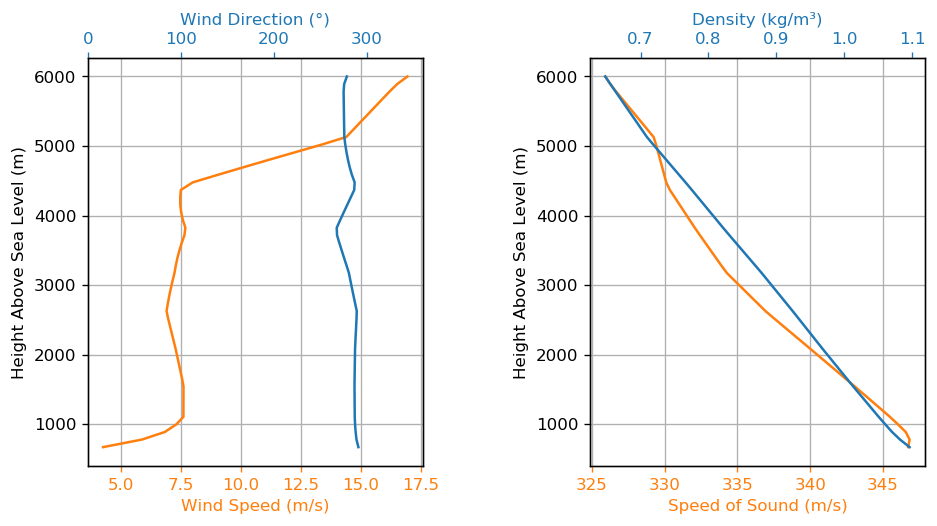

In [14]:
Env = Environment(railLength= 50,            # Comprimento validado
                  gravity=9.8,
                  date=(2020, 11, 29, 12),
                  latitude=-23.363611,             #Lat-lon confirmadas
                  longitude=-48.011389,
                  elevation=668)                 

Env.setAtmosphericModel(type='CostumAtmosphere',
                         pressure='data/weather/Valetudo/valetudo_launch_20190810T210000Z_pressure.csv',
                         temperature='data/weather/Valetudo/valetudo_launch_20190810T210000Z_temperature.csv',
                         wind_u='data/weather/Valetudo/valetudo_launch_20190810T210000Z_wind-u.csv',
                         wind_v='data/weather/Valetudo/valetudo_launch_20190810T210000Z_wind-v.csv')
Env.maxExpectedHeight = 6000

Env.info()

# Motor Data


Motor Details
Total Burning Time: 100 s
Total Propellant Mass: 4549.812 kg
Propellant Exhaust Velocity: 4945.260 m/s
Average Thrust: 225000.000 N
Maximum Thrust: 569069.972884627 N at 0.17006802721088435 s after ignition.
Total Impulse: 22500000.000 Ns

Plots


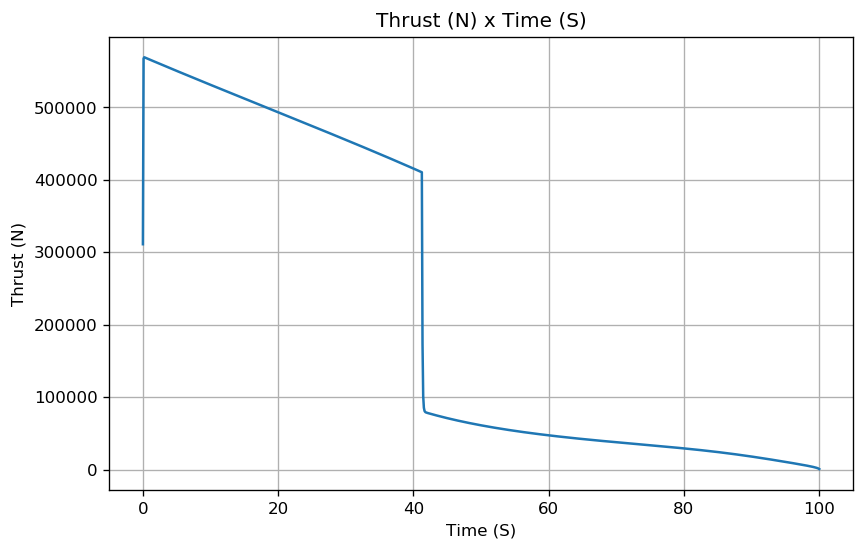

In [30]:
MARIMBONDO  = SolidMotor(thrustSource='data/Hibrido/EmpSimHibNHNE.csv',
                          burnOut=7.04,
                          reshapeThrustCurve= (100,22500000),
                          grainNumber=1,
                          grainSeparation=0,
                          grainOuterRadius= 0.5,
                          grainInitialInnerRadius=0.25,
                          grainInitialHeight=2,
                          grainDensity= 3862,               #Considerando a massa de óxido nitroso
                          nozzleRadius=0.5,
                          throatRadius=0.13,
                          interpolationMethod='linear')


MARIMBONDO.info()

# Find the Pressure at Main parachute deployment height



In [31]:
main_deployment_height_AGL = 530 #m                                
 
main_deployment_height_ASL = main_deployment_height_AGL + Env.elevation   # This is the Main parachute deployment altitude above sea level

p = Env.pressure(main_deployment_height_ASL)    # This is the Pressure at Main parachute deployment height

print('Pressure at', main_deployment_height_AGL, 'm (AGL) =', p, 'Pa =', p/(10**5), 'bar')

Pressure at 530 m (AGL) = 88633.58747628177 Pa = 0.8863358747628177 bar


# Importing the SRAD avionics algorithm for parachute deployment signal

In [32]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 m.
    return True if y[5] < 0 and y[2] < 800 else False


# Rocket Data

In [33]:
#help(Rocket)

Inertia Details
Rocket Mass: 1250.000 kg (No Propellant)
Rocket Mass: 5799.812 kg (With Propellant)
Rocket Inertia I: 21820.000 kg*m2
Rocket Inertia Z: 311.000 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -7 m
Rocket Center of Mass - Propellant Center of Mass Distance: -4 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -3.138 m

Aerodynamic Coponents Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 161.636/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 9.750 m
Fins Center of Pressure to CM: -6.917 m
Distance - Center of Pressure to CM: -6.713 m
Initial Static Margin: 17.875 c
Final Static Margin: 33.565 c

Mass Plots


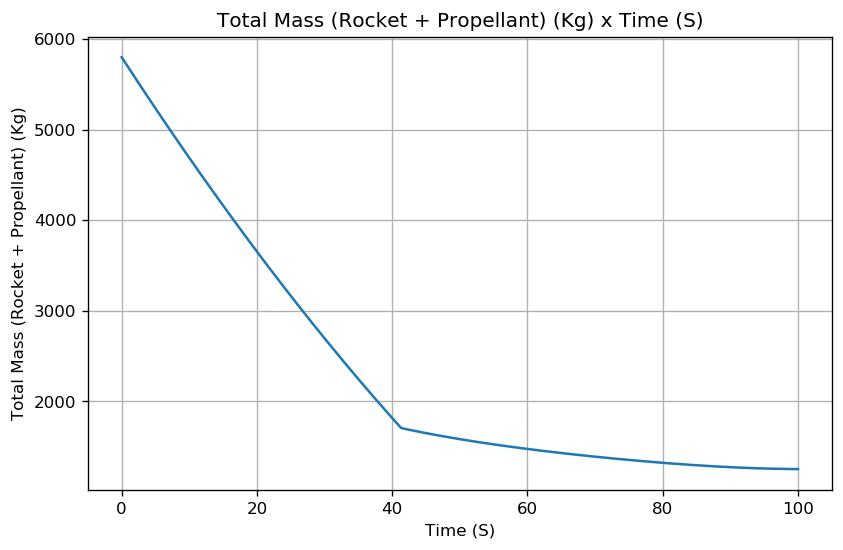

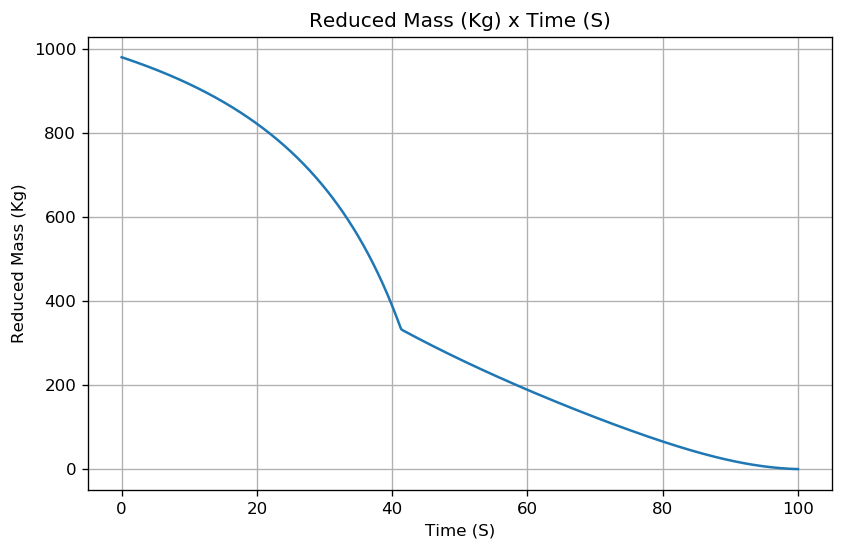


Aerodynamics Plots


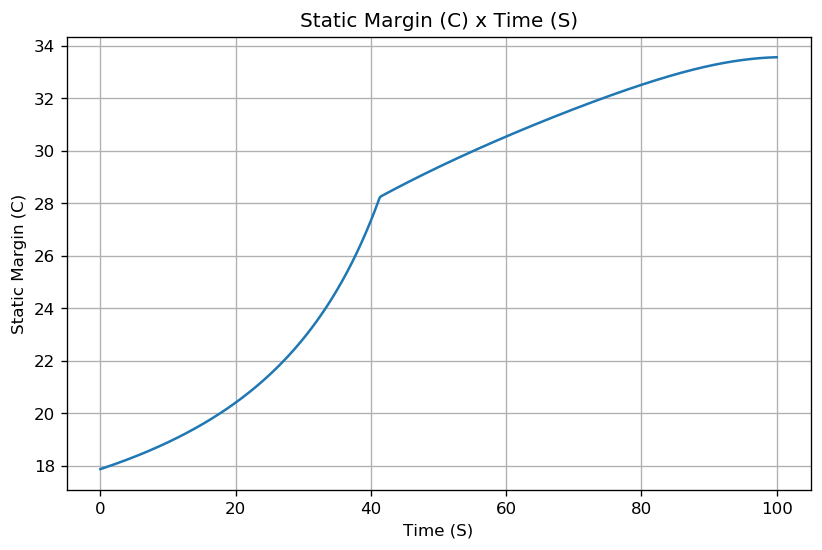

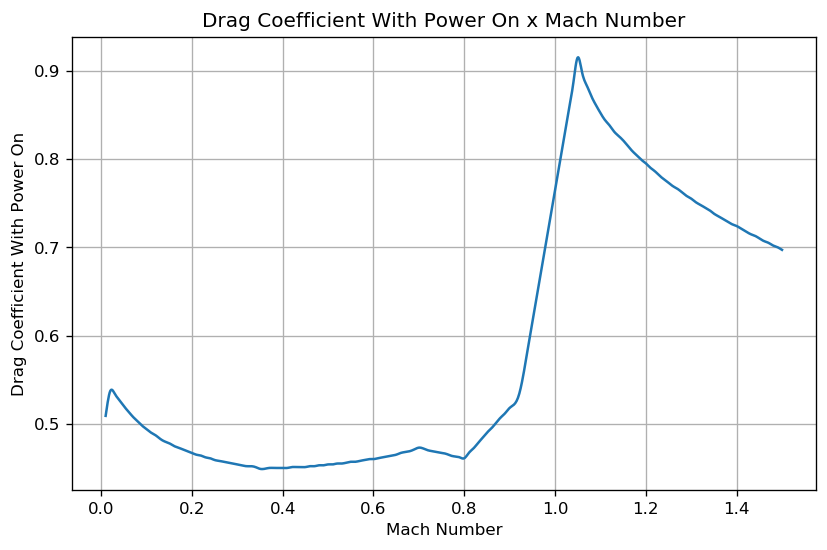

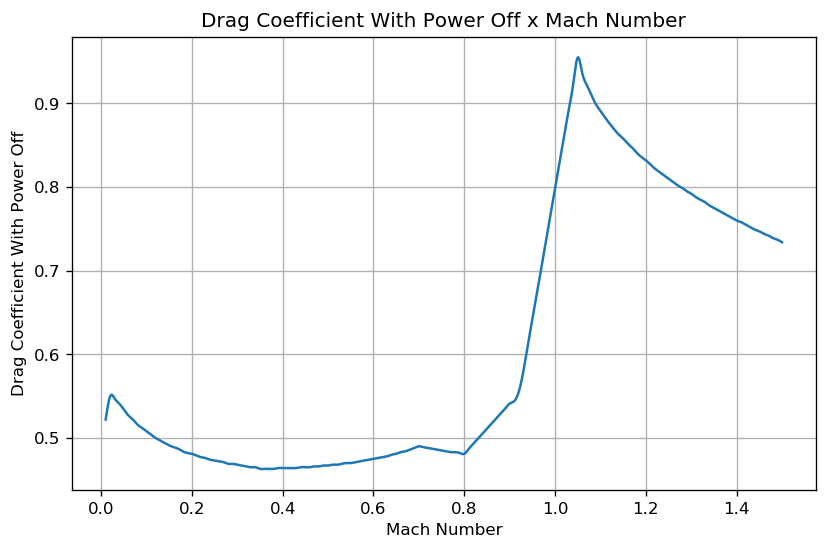

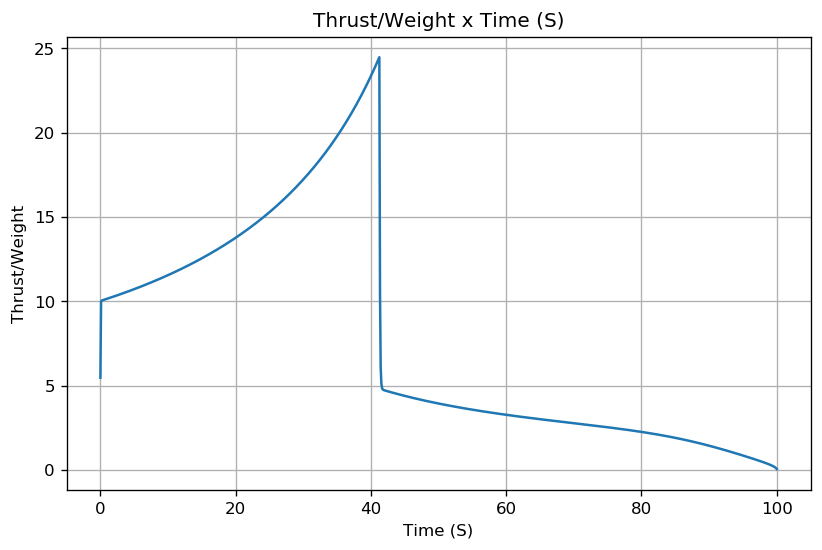

In [36]:
# Próximos valores são relativos a um sistema de coordenadas com origem no bico da ogiva

Posição_CMgraos = 15       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
Posição_aletas  = 17.5         # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
#Posição_cauda   = 3024.29 /1000       # Posição da transição entre o corpo cilíndrico do foguete e a cauda, que em geral é um tronco de cone ou não existe mesmo
Posição_nozzle  = 18      # Posição da saída do Nozzle (bocal). É também a posição da seção de maior diâmetro do nozzle
Posição_CM_descarregado = 11    # Posição do Centro de Massa do foguete sem os grãos de propelente ou espaçadores entre grãos


# A partir de agora nosso sistema de coordenadas passa a ter origem no centro de massa do foguete descarregado

EUROPA = Rocket(motor= MARIMBONDO,
                radius= 0.1,
                mass= 1250,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                inertiaI= 21820,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                inertiaZ= 311,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                powerOffDrag='data/europa/Europa_drag_power_off.csv',
                powerOnDrag='data/europa/Europa_drag_power_on.csv')

EUROPA.addNose(length=2.5, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 2.5))

EUROPA.addFins(4, span = 1, rootChord = 1, tipChord = 0.5, distanceToCM= Posição_CM_descarregado - Posição_aletas,) #airfoil = 'data/europa/NACA0012_Cl_em_radianos.csv')

#EUROPA.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM= Posição_CM_descarregado - Posição_cauda)

EUROPA.setRailButtons([1, -3], 45)
#Drogue = EUROPA.addParachute('Drogue',
#                     CdS= 1,
#                     trigger=drogueTrigger, 
#                     samplingRate=105,
#                     noise=(0, 8.3, 0.5),
#                     lag=1.0)

# Main = EUROPA.addParachute('Main',
#                      CdS=4.3,
#                      trigger=mainTrigger, 
#                      samplingRate=105,
#                      noise=(0, 8.3, 0.5),
#                      lag=1.0)

  
EUROPA.allInfo()

## Enable avionics systems before flight (Remove before flight)

# Finally, the Trajectory Simulation

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 668.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: -0.766 | e1: 0.588 | e2: 0.158 | e3: -0.205
Euler Angles - Spin φ : 0.00° | Nutation θ: -75.00° | Precession ψ: -330.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 15.00°
Launch Rail Heading: 330.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -3.31 m/s
Lateral Surface Wind Speed: -2.69 m/s


 Rail Departure State

Rail Departure Time: 0.945 s
Rail Departure Velocity: 90.014 m/s
Rail Departure Static Margin: 17.957 c
Rail Departure Angle of Attack: 1.807°
Rail Departure Thrust-Weight Ratio: 10.140
Rail Departure Reynolds Number: 1.110e+06


BurnOut State

BurnOut time: 100.000 s
Altitude at burnOut: -31058.531 m (AGL)
Rocket velocity at burnOut: 1748.580 m/s
Freestream velocity at burnOut: 1750.986 m/s
Mach Number at burnOut: 5.027
Kinetic energy at burnOut: 1.911e+0

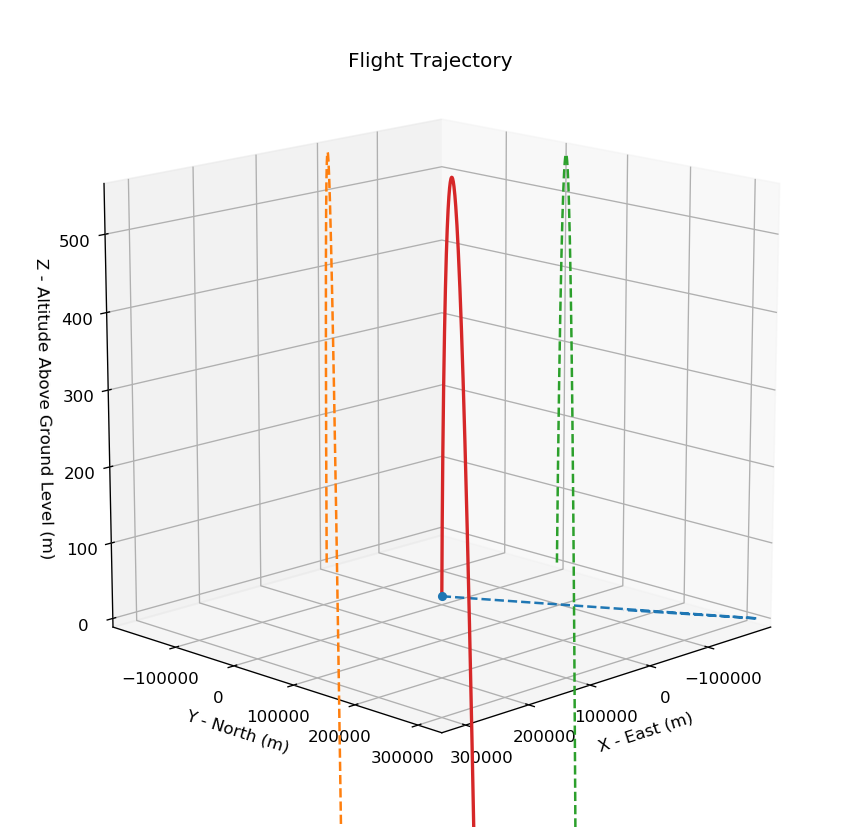



Trajectory Kinematic Plots



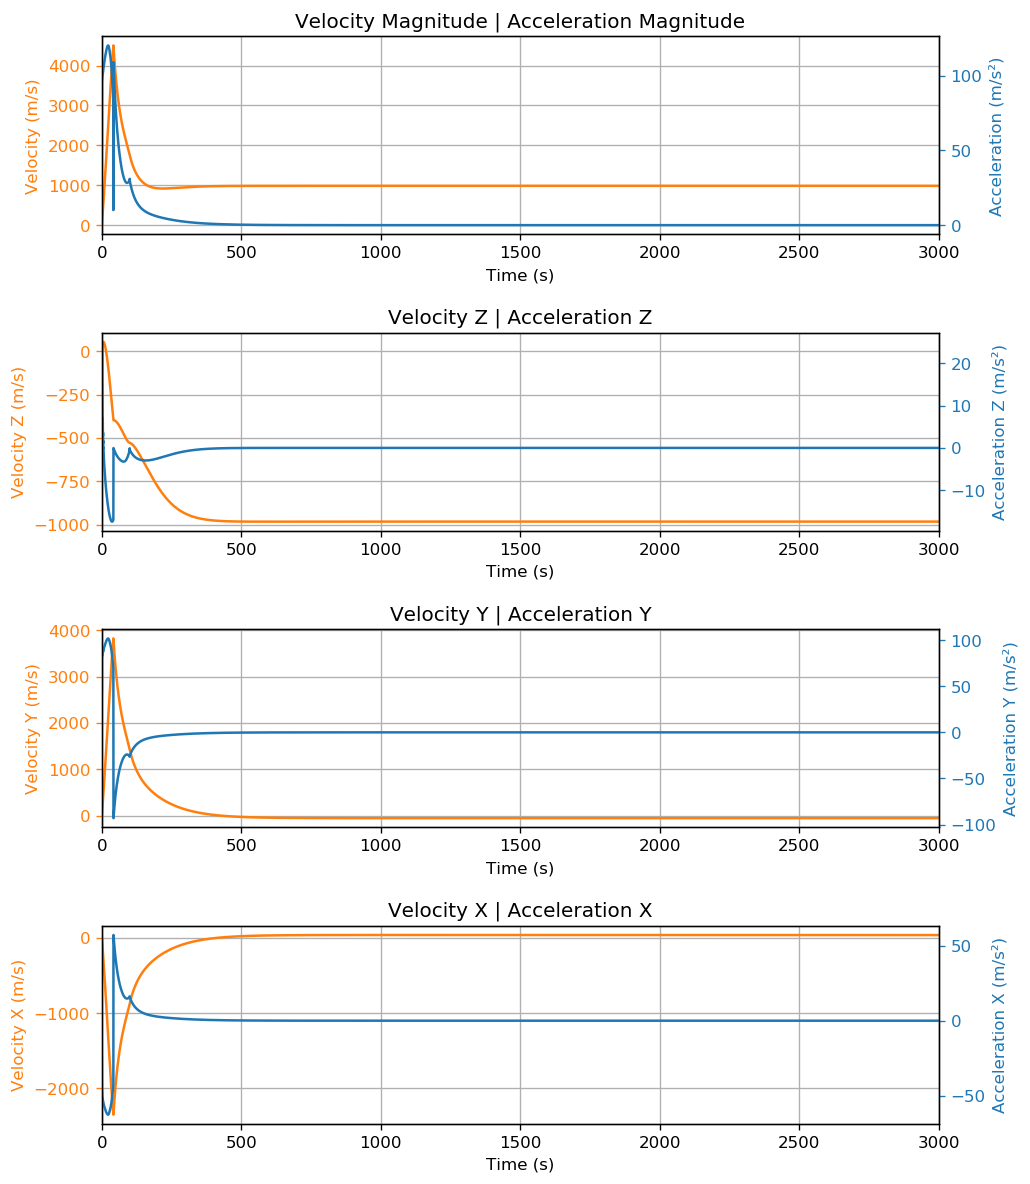



Angular Position Plots



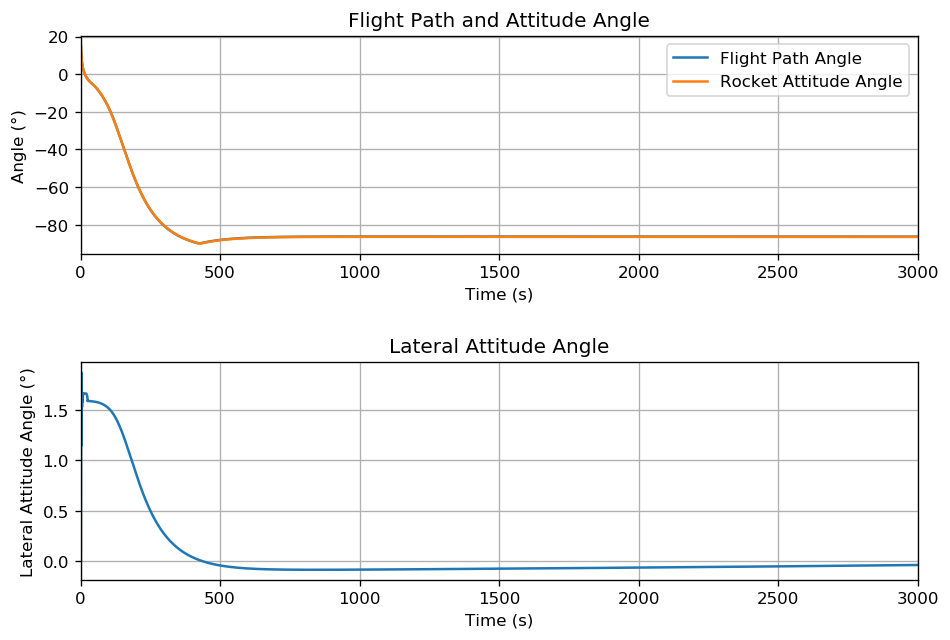



Path, Attitude and Lateral Attitude Angle plots



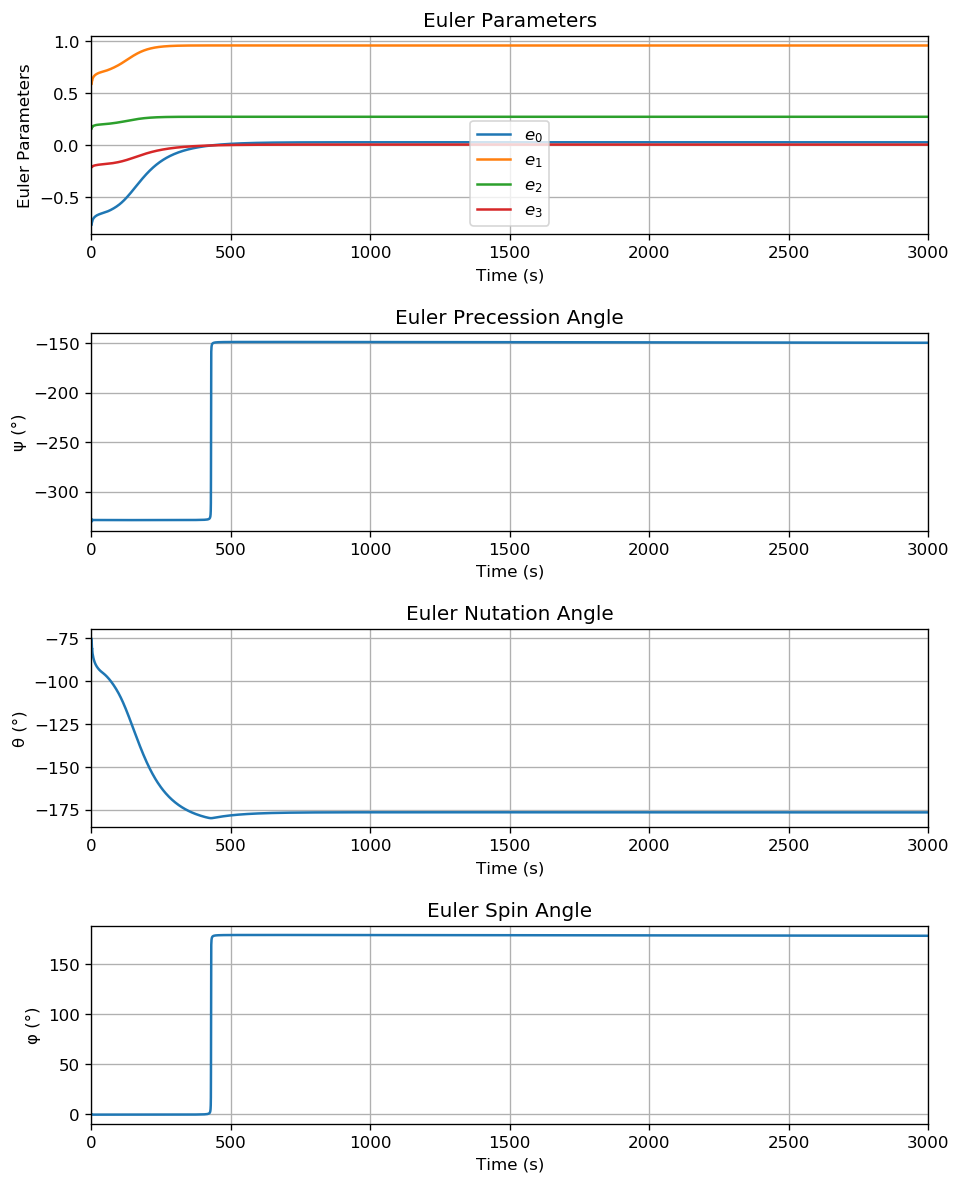



Trajectory Angular Velocity and Acceleration Plots



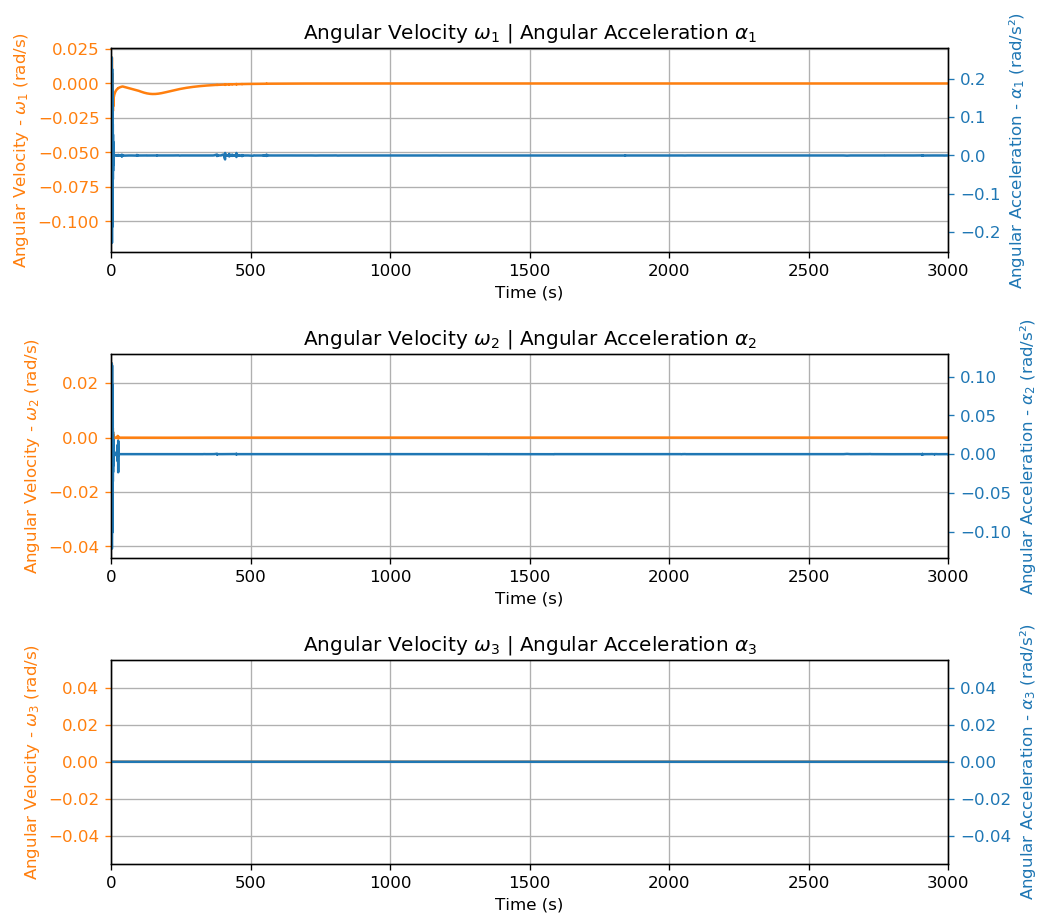



Trajectory Force Plots



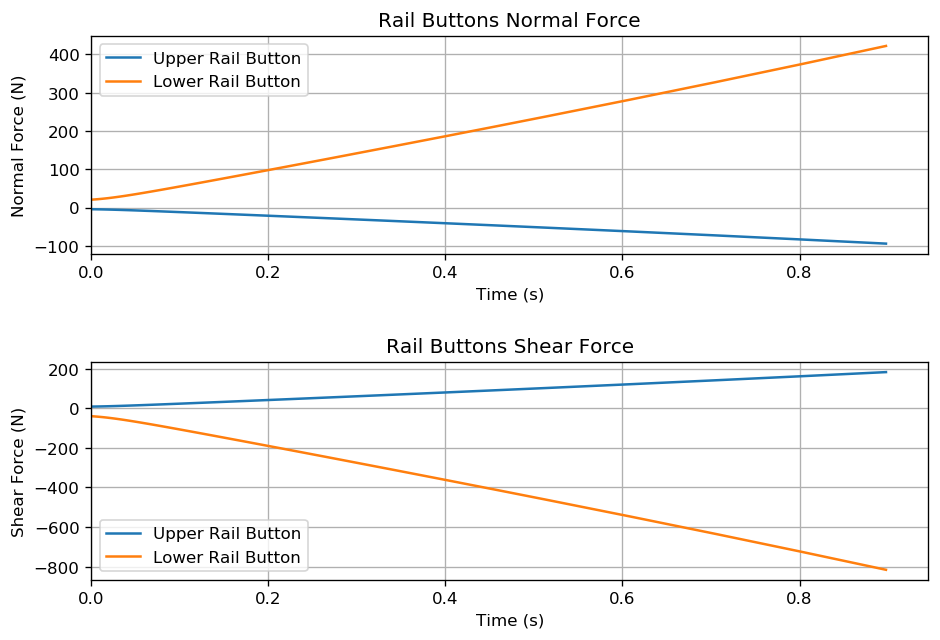

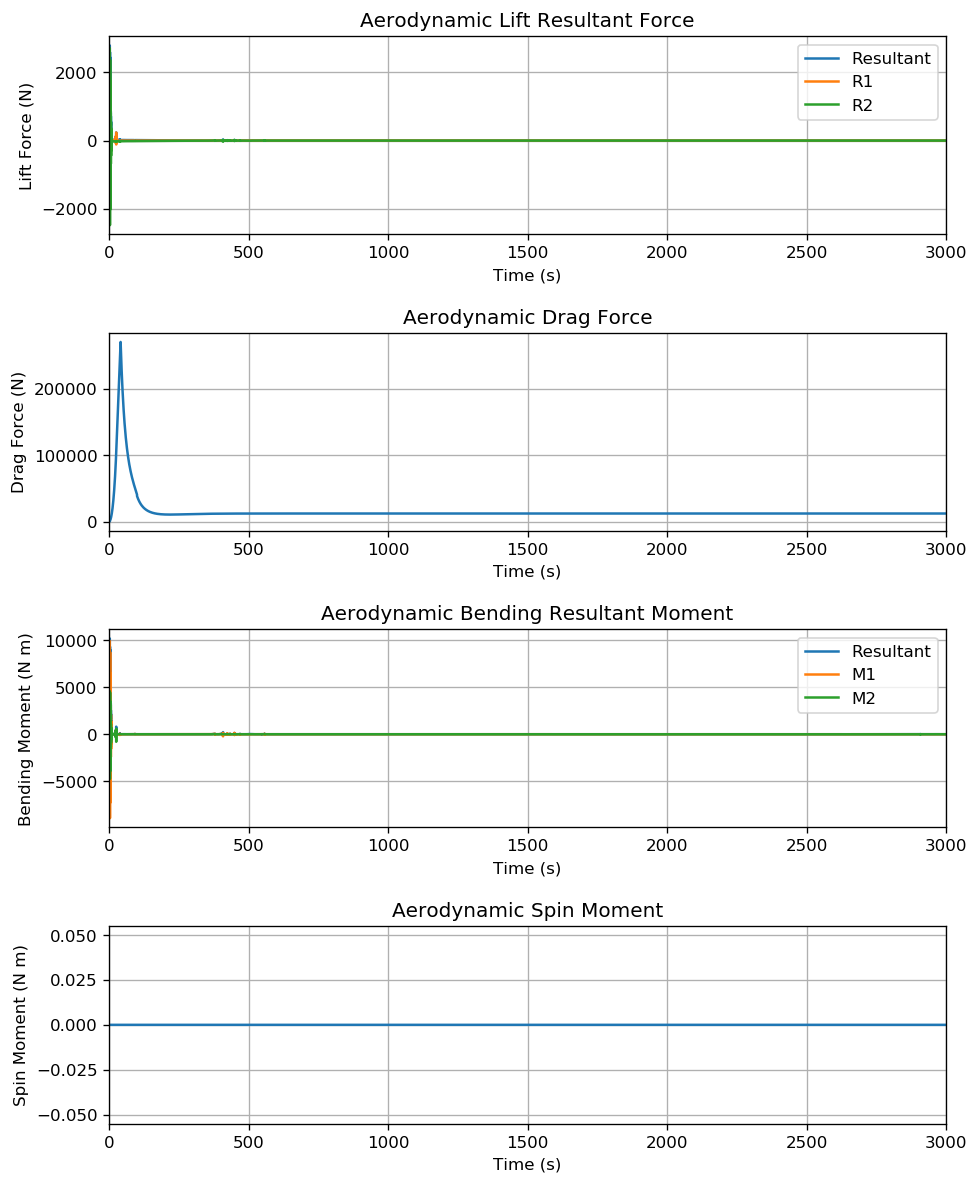



Trajectory Energy Plots



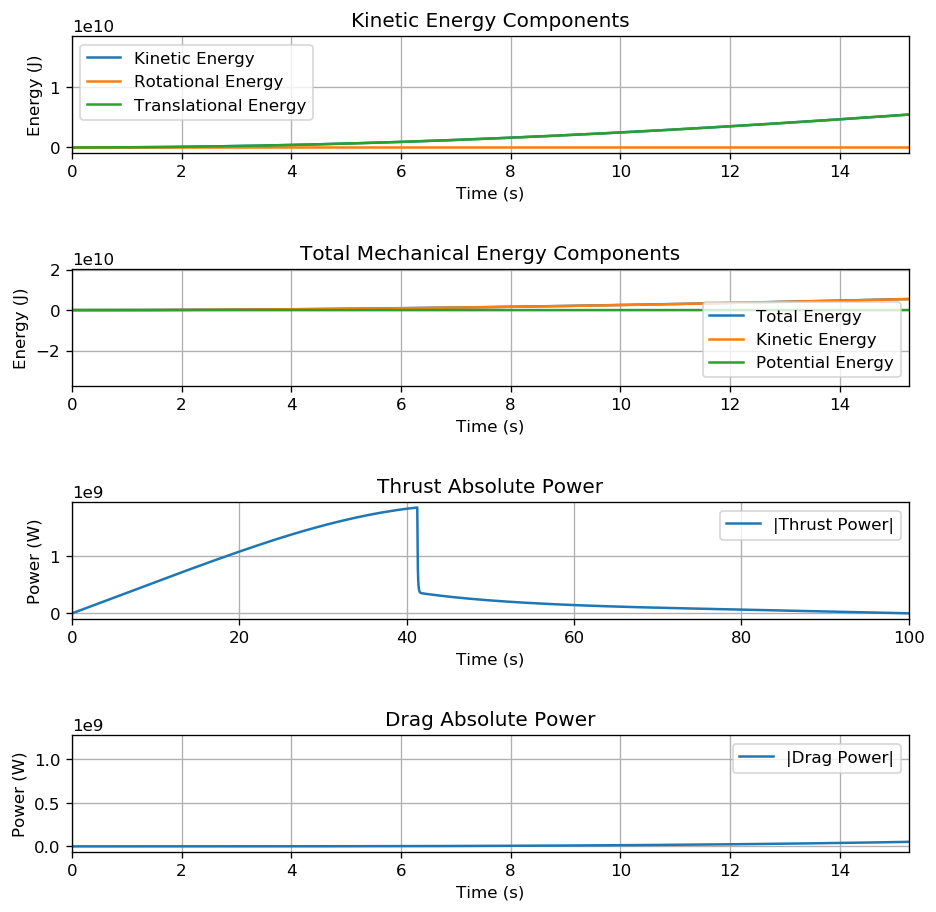



Trajectory Fluid Mechanics Plots



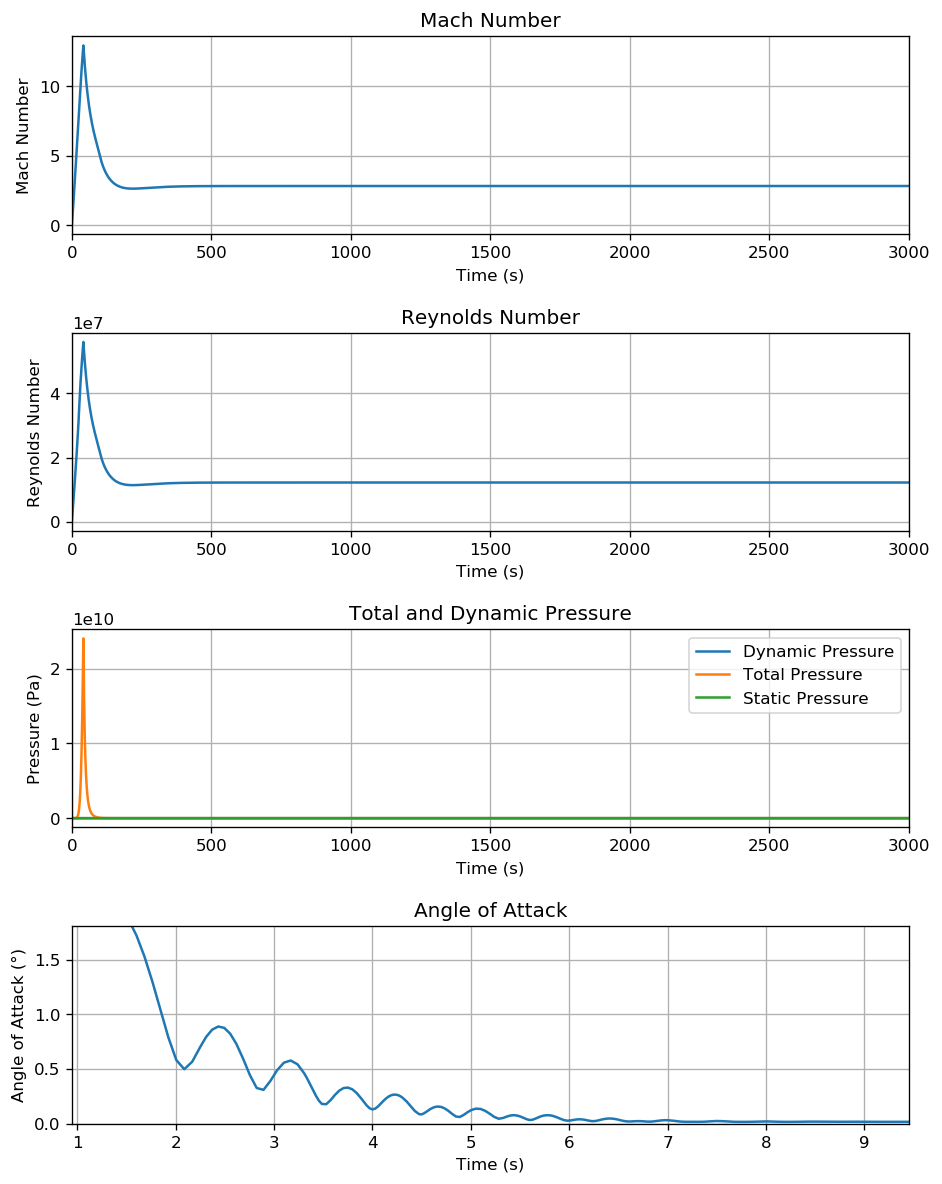



Trajectory Stability and Control Plots



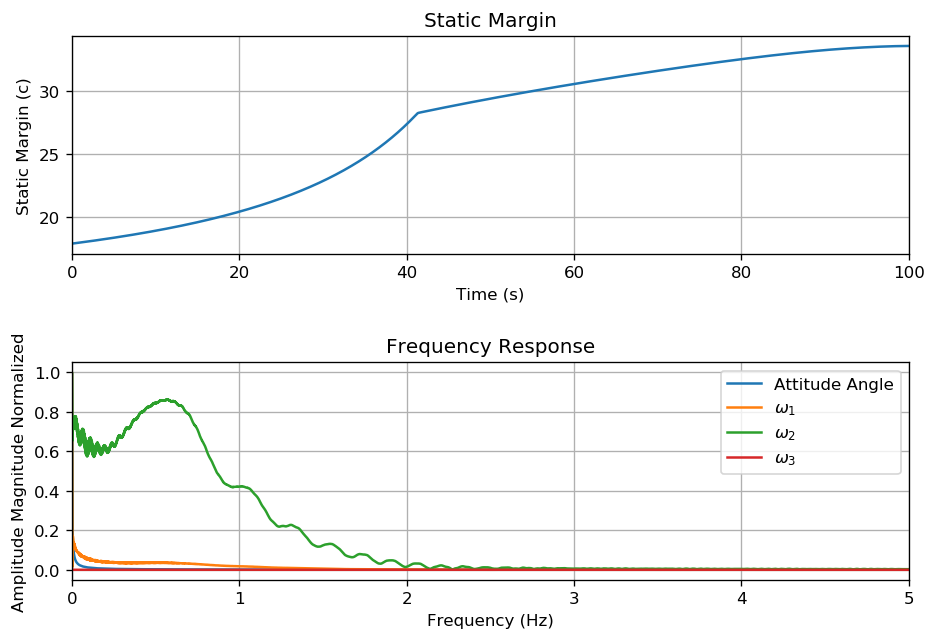

In [43]:
TestFlight = Flight(rocket=EUROPA, environment=Env, inclination=15, heading=330, rtol=1e-6, atol=1e-6, maxTime=3000, orbitalFlight=True)
TestFlight.allInfo()
TestFlight.postProcess()
#TestFlight.info()


In [ ]:
#%matplotlib 

In [12]:
#TestFlight.animate()

# Fin optmization

In [13]:
FOGUETON = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= 24.5,                 # Pegar a massa do foguete no CAD, desconsiderar a massa do propelente
                inertiaI= 16.17,          # Não esquecer de pegar no CAD com o Foguete Descarregado
                inertiaZ= 0.077,           # Não esquecer de pegar no CAD com o Foguete Descarregado
                distanceRocketNozzle= Posição_CM_descarregado - Posição_nozzle,
                distanceRocketPropellant= Posição_CM_descarregado - Posição_CMgraos,
                powerOffDrag='data/europa/Mach x CD - Página1 - Mach x CD - Página1.csv',
                powerOnDrag='data/europa/Mach x CD - Página1 - Mach x CD - Página1.csv')

FOGUETON.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

import numpy as np

n = 3          #n de aletas
spanMin = 0.05
rootMin = 0.05
tipMin = 0.02
spanMax = 0.120
rootMax = 0.15
tipMax = 0.08
distanceToCM = Posição_CM_descarregado - Posição_aletas
paces=0.003
desiredStaticMargin=2

def MeritFunction(staticMargin, desiredStaticMargin, areaFins):
  sigma = 0.2
  return (np.exp(-1*(((staticMargin - desiredStaticMargin)/(2*sigma))**2)))/areaFins

# Stabilishing basic parameters
span = spanMin
root = rootMin
tip = tipMin
highestMerit = 0

while span <= spanMax:
  while root <= rootMax:
    while tip <= tipMax:
      FOGUETON.addFins(n, span, root, tip, distanceToCM)
      staticMargin = FOGUETON.staticMargin(0)
      afterBurnStaticMargin  = FOGUETON.staticMargin(10)
      areaFins = (root + tip) * (span / 2)
      merit = MeritFunction(staticMargin, desiredStaticMargin, areaFins)

      # Saves best Merit value
      if merit > highestMerit:
        highestMerit = merit
        highestMargin = staticMargin
        highestAfterBurnMargin = afterBurnStaticMargin
        spanFinal = span
        rootFinal = root
        tipFinal = tip

      # Removes added fins from rocket
      FOGUETON.aerodynamicSurfaces.pop(-1)

      tip += paces

    root += paces
    tip = tipMin

  span += paces
  root = rootMin
        
print("span: %.3f  root: %.3f  tip: %.3f"%(spanFinal,rootFinal,tipFinal))
print("Merit: %f  |  Margin: %f  |  After Burn Margin: %f"%(highestMerit,highestMargin,highestAfterBurnMargin))

span: 0.119  root: 0.149  tip: 0.077
Merit: 24.698016  |  Margin: 1.580043  |  After Burn Margin: 2.102933


# Plot a "Apogee x Rocket Mass" chart





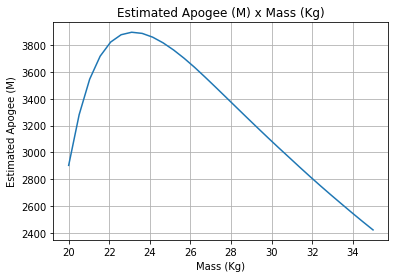

In [14]:
def apogee(mass):
  massa_total_cad = mass
  massa_propelente = 5.345
  massa_unloaded = mass - massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  
  return TF.apogee - Env.elevation
  
apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(20,35,30)

# Plot a "Out of Rail Velocity x Rocket Mass" chart

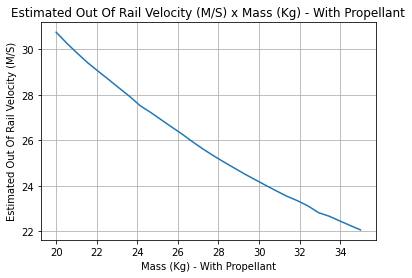

In [15]:
def vel(mass):
  massa_total_cad = mass
  massa_propelente = 5.345
  massa_unloaded = mass - massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  return TF.outOfRailVelocity

velbymass = Function(vel, inputs="Mass (kg) - with propellant", outputs="Estimated Out Of Rail Velocity (m/s)")
velbymass.plot(20,35, 30)

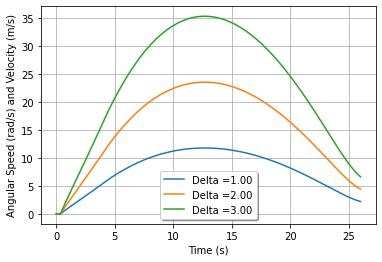

In [18]:
def flight(delta_fin):
  massa_unloaded = 24.5
  massa_propelente = 5.345
  massa_total_cad = massa_unloaded + massa_propelente
  
  Posição_CM_graos = 2660.8 /1000       # Posição do centro de massa de todos os grãos e espaçadores, em metros 
  Posição_aletas  = (3209.7 - 16) /1000          # Posição das Aletas no CAD, considerar o ponto de encontro da aleta com o corpo do foguete mais próximo da origem
  Posição_nozzle  = 3425.79 /1000
  Posição_CM_descarregado = 2216 /1000
  
  
  R = Rocket(motor= MARIMBONDO,
                radius= 127/2000,
                mass= massa_unloaded,
                inertiaI=16.17,
                inertiaZ=0.077,
                distanceRocketNozzle= -abs(Posição_CM_descarregado - Posição_nozzle),
                distanceRocketPropellant= -abs(Posição_CM_descarregado - Posição_CM_graos),
                powerOffDrag=EUROPA.powerOffDrag,
                powerOnDrag=EUROPA.powerOffDrag)

  R.addNose(length=558.29/1000, kind="vonKarman", distanceToCM= abs(Posição_CM_descarregado - 558.29/1000))

  R.addFins(4, span = 0.09, rootChord = 0.1, tipChord = 0.020, distanceToCM= Posição_CM_descarregado - Posição_aletas, delta=delta_fin)

  R.setRailButtons([Posição_CM_descarregado - 2.086, Posição_CM_descarregado - 3.397], 45)
      
  TF = Flight(rocket=R, environment=Env, inclination=85, terminateOnApogee=True, heading=45)
  TF.postProcess()
  return TF.w3 

def omega(min, max, step):
    #simulation_results = [(TestFlight.speed, 'Velocity magnitute')]
    simulation_results = []
    for delta in range(min, max+1, step):
        #simulation_results.append(flight(delta))
        simulation_results += [(flight(delta), 'Delta =' + '{:1.2f}'.format(delta))]
    Function.comparePlots(simulation_results,lower=0, upper=26, xlabel='Time (s)', ylabel='Angular Speed (rad/s) and Velocity (m/s)')

omega(1,3,1)

# Saving all results as .html

In [17]:
!jupyter nbconvert --output-dir='/gdrive/Shared drives/O Projeto Jupiter/Aerodinâmica/RocketPy/Reports/Europa/LASC 2020/' --to html "Europa Hibrido Flight Simulation.ipynb" --output "Europa_Hibrido_Flight_Simulation_Oct_16.ipynb"

[NbConvertApp] WARNING | pattern 'drives/O' matched no files
[NbConvertApp] WARNING | pattern 'Projeto' matched no files
[NbConvertApp] WARNING | pattern 'Jupiter/Aerodinâmica/RocketPy/Reports/Europa/LASC' matched no files
[NbConvertApp] WARNING | pattern "2020/'" matched no files
[NbConvertApp] Converting notebook Europa Hibrido Flight Simulation.ipynb to html
[NbConvertApp] Writing 1845733 bytes to '/gdrive/Shared\Europa_Hibrido_Flight_Simulation_Oct_16.ipynb.html
